In [23]:
import numpy as np

import skrf
from skrf.media import DistributedCircuit
import skrf.frequency as freq
import skrf.network as net
import skrf.util

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

f = freq.Frequency(0.4, 2, 1001)
tem = DistributedCircuit(f, z0=50)

bjt = net.Network('BFU520_Spar_NF_400MHz-2GHz/BFU520_05V0_005mA_NF_SP.s2p').interpolate(f)

bjt

2-Port Network: 'BFU520_05V0_005mA_NF_SP',  0.4-2.0 GHz, 1001 pts, z0=[ 50.+0.j  50.+0.j]

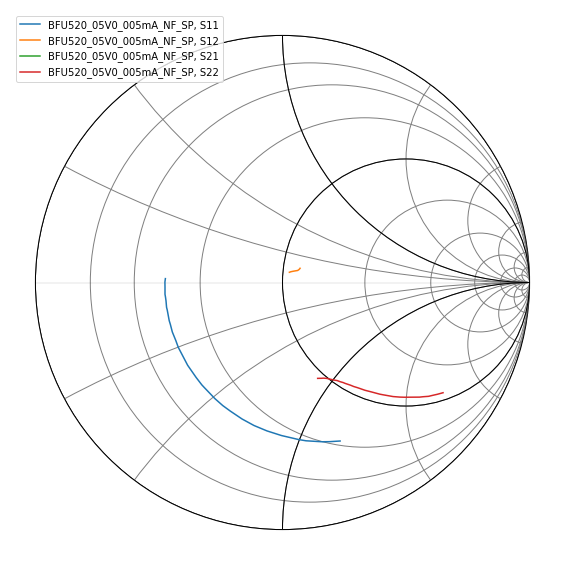

In [24]:
bjt.plot_s_smith()

In [25]:
# calculate the stability circles for the source and load impedances

idx_900mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

sqabs = lambda x: np.square(np.absolute(x))

delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
rl = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s22.s) - sqabs(delta)))
cl = np.conj(bjt.s22.s - delta*np.conj(bjt.s11.s))/(sqabs(bjt.s22.s) - sqabs(delta))

rl_900mhz = rl[idx_900mhz][0, 0]
cl_900mhz = cl[idx_900mhz][0, 0]

rl_900mhz, cl_900mhz

(2.8394677846594996, (1.2371751344204285+3.2424616116062022j))

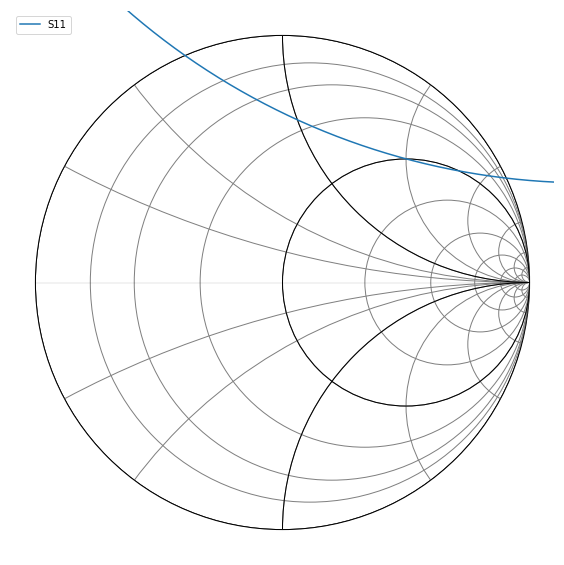

In [26]:
def calc_circle(c, r):
    theta = np.linspace(0, 2*np.pi, 1000)
    return c + r*np.exp(1.0j*theta)

def plot_smith(pts):
    n = net.Network(s=pts)
    n.plot_s_smith()
    
cl_points = calc_circle(cl_900mhz, rl_900mhz)
plot_smith(cl_points)

In [27]:
rs = np.absolute((bjt.s12.s * bjt.s21.s)/(sqabs(bjt.s11.s) - sqabs(delta)))
cs = np.conj(bjt.s11.s - delta*np.conj(bjt.s22.s))/(sqabs(bjt.s11.s) - sqabs(delta))

rs_900mhz = rs[idx_900mhz][0, 0]
cs_900mhz = cs[idx_900mhz][0, 0]

rs_900mhz, cs_900mhz

(3.1199726116705513, (-2.9669977643038008+2.2819464699039518j))

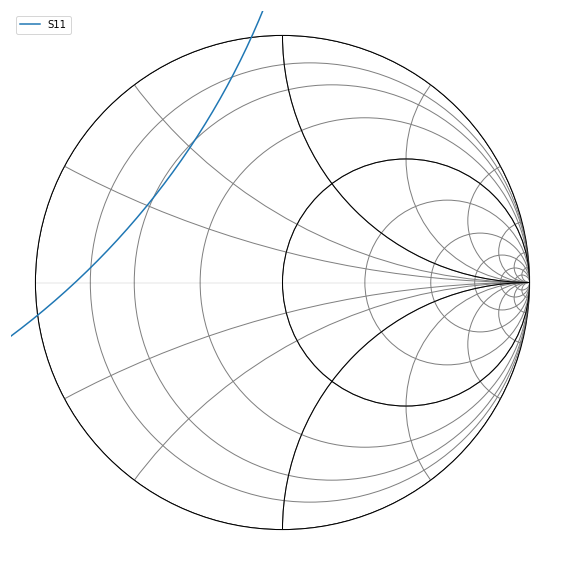

In [28]:
cs_points = calc_circle(cs_900mhz, rs_900mhz)
plot_smith(cs_points)

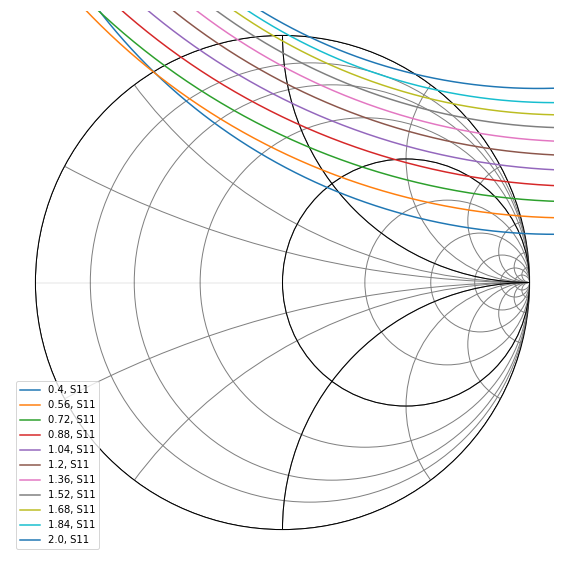

In [29]:
# let's plot all of them
# output stability first

for i, f in enumerate(bjt.f):
    # decimate it a little
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cl[i][0, 0], rl[i][0, 0]))
    n.plot_s_smith()

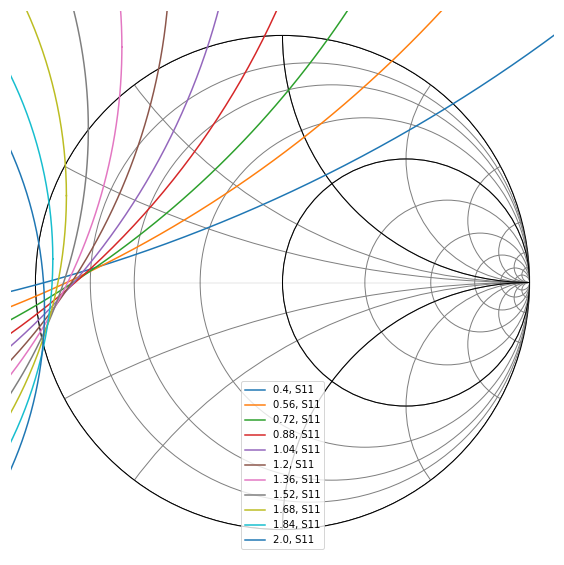

In [30]:
# input stability
for i, f in enumerate(bjt.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs[i][0, 0], rs[i][0, 0]))
    n.plot_s_smith()

the optimum source reflection coefficient is  (0.0983297857508+0.147483438082j)


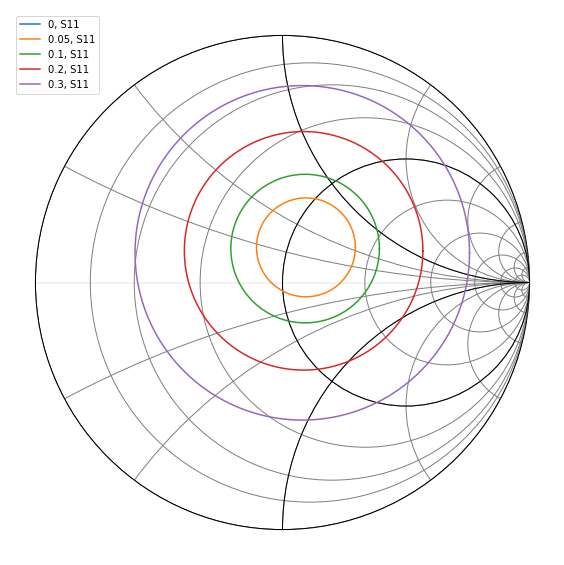

In [31]:
# let's draw some constant noise circles
# first we grab the noise parameters for our target frequency from the network model
idx_915mhz = skrf.util.find_nearest_index(bjt.f, 915.e+6)

# we need the normalized equivalent noise and optimum source coefficient to calculate the constant noise circles
rn = bjt.rn[idx_915mhz]/50
gamma_opt = bjt.g_opt[idx_915mhz]
fmin = bjt.nfmin[idx_915mhz]

for nf_added in [0, 0.05, 0.1, 0.2, 0.3]:
    nf = 10**(nf_added/10) * fmin
    
    N = (nf - fmin)*abs(1+gamma_opt)**2/(4*rn)
    c_n = gamma_opt/(1+N)
    r_n = 1/(1-N)*np.sqrt(N**2 + N*(1-abs(gamma_opt)**2))
    
    n = net.Network(name=str(nf_added), s=calc_circle(c_n, r_n))
    n.plot_s_smith()

print("the optimum source reflection coefficient is ", gamma_opt)

In [32]:
gamma_s = bjt.g_opt[idx_900mhz]
gamma_s

(0.098329785750829277+0.14748343808162145j)

In [33]:
# so I need to calculate the load reflection coefficient to get a conjugate match when the input sees 50 ohms
gamma_l = np.conj(bjt.s22.s - bjt.s21.s*gamma_s*bjt.s12.s/(1-bjt.s11.s*gamma_s))
is_gamma_l_stable = np.absolute(gamma_l[idx_900mhz, 0, 0] - cl_900mhz) > rl_900mhz

gamma_l = gamma_l[idx_900mhz, 0, 0]
gamma_l, is_gamma_l_stable

((0.42267113183938537+0.4147830810062007j), True)

In [34]:
def calc_matching_network_vals(z1, z2):
    flipped = ((abs(np.imag(z2)) < 1e-6 and np.real(z1) < np.real(z2)) or
            (abs(np.imag(z2)) > 1e-6 and np.real(z1) < np.real(1/(1/z2-1/(1.j*np.imag(z2))))))
    if flipped:
        z2, z1 = z1, z2
        
    # cancel out the imaginary parts of both input and output impedances    
    z1_par = 1e+10
    if abs(np.imag(z1)) > 1e-6:
        # parallel something to cancel out the imaginary part of
        # z1's impedance
        z1_par = 1/(-1j*np.imag(1/z1))
        z1 = 1/(1./z1 + 1/z1_par)
    z2_ser = 0.0
    if abs(np.imag(z2)) > 1e-6:
        z2_ser = -1j*np.imag(z2)
        z2 = z2 + z2_ser
        
    Q = np.sqrt((np.real(z1) - np.real(z2))/np.real(z2))
    x1 = -1.j * np.real(z1)/Q
    x2 = 1.j * np.real(z2)*Q
    
    x1_tot = 1/(1/z1_par + 1/x1)
    x2_tot = z2_ser + x2
    if flipped:
        return x2_tot, x1_tot
    else:
        return x1_tot, x2_tot

z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]
# note that we're matching against the conjugate;
# this is because we want to see z_l from the BJT side
# if we plugged in z the matching network would make
# the 50 ohms look like np.conj(z) to match against it, so
# we use np.conj(z_l) so that it'll look like z_l from the BJT's side
z_par, z_ser = calc_matching_network_vals(np.conj(z_l), 50)
z_l, z_par, z_ser

((64.242549793673973+82.077788585900919j),
 -636.2306653569593j,
 77.17093294453807j)

In [35]:
# let's calculate what the component values are
c_par = np.real(1/(2j*np.pi*915e+6*z_par))
l_ser = np.real(z_ser/(2j*np.pi*915e+6))

c_par, l_ser

(2.7339114253184115e-13, 1.3423098842772051e-08)

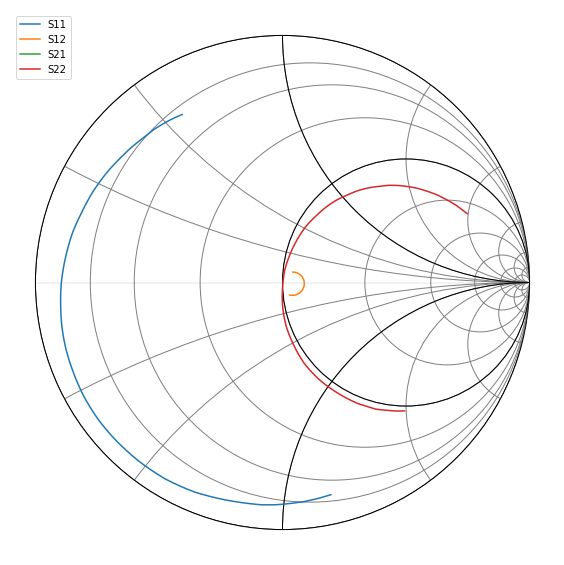

In [36]:
# the capacitance is kind of low but the inductance seems reasonable
# let's test it out

output_network = tem.inductor(l_ser) ** tem.shunt_capacitor(c_par)

amplifier = tem.inductor(1.3e-9) ** bjt ** output_network

amplifier.plot_s_smith()

0.78454633962737463

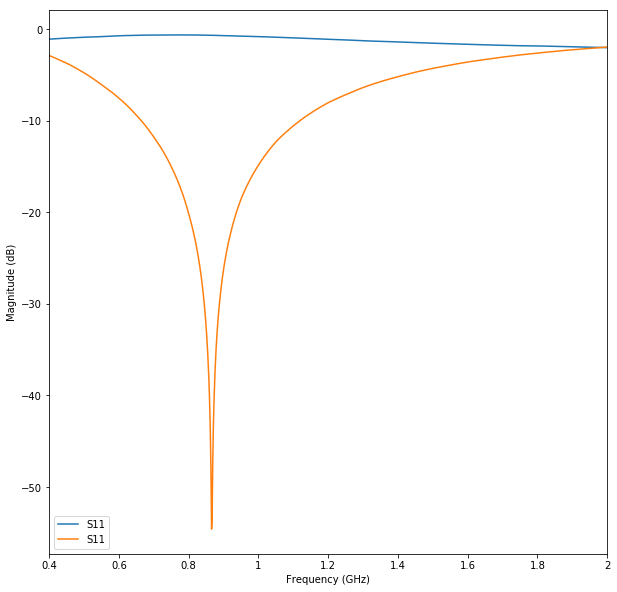

In [37]:
amplifier.s11.plot_s_db()
amplifier.s22.plot_s_db()
10*np.log10(amplifier.nf(50.)[idx_900mhz])

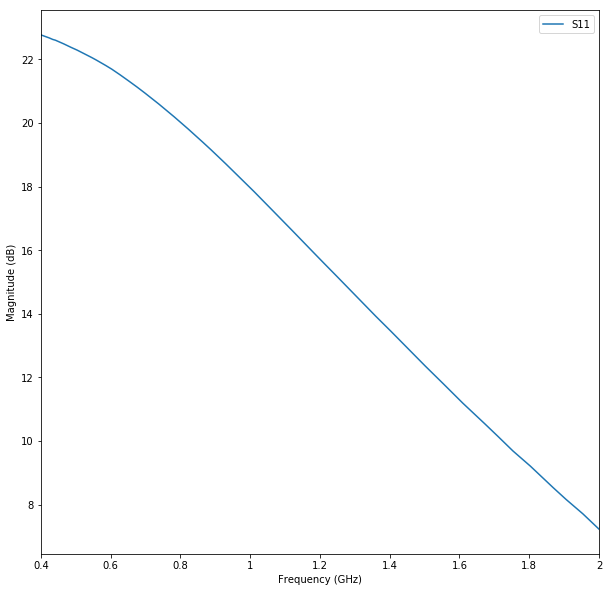

In [38]:
amplifier.s21.plot_s_db()

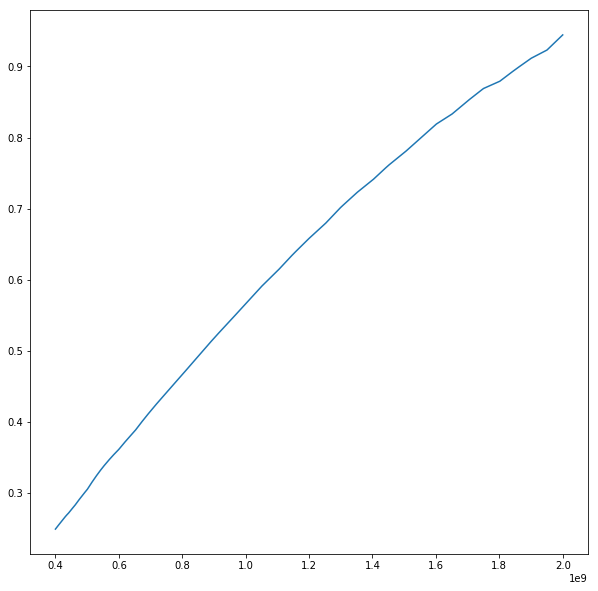

In [39]:
# that's probably good enough for the first stage
# for the second stage let's stabilize the transistor by adding some parallel resistance
# and then simultaneous conjugate matching so that both the input and output are matched to 50 ohms

# let's calculate the stability factor to see where it's unstable
sqabs = lambda x: np.square(np.absolute(x))
delta = bjt.s11.s*bjt.s22.s - bjt.s12.s*bjt.s21.s
K = ((1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta))/(2*np.absolute(bjt.s12.s*bjt.s21.s)))[:,0,0]

plt.plot(bjt.f, K)

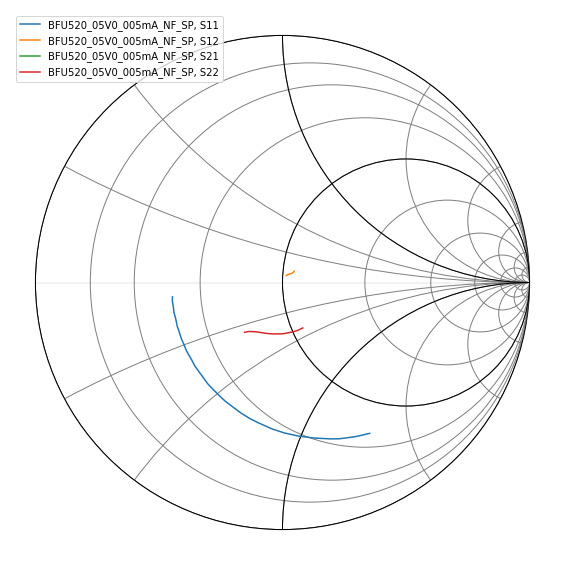

In [68]:
#so it's basically always unstable
#let's add a 250 ohm shunt to the output and see how much that improves it

bjt_comp = bjt ** tem.shunt(tem.resistor(75.) ** tem.short())
bjt_comp.plot_s_smith()

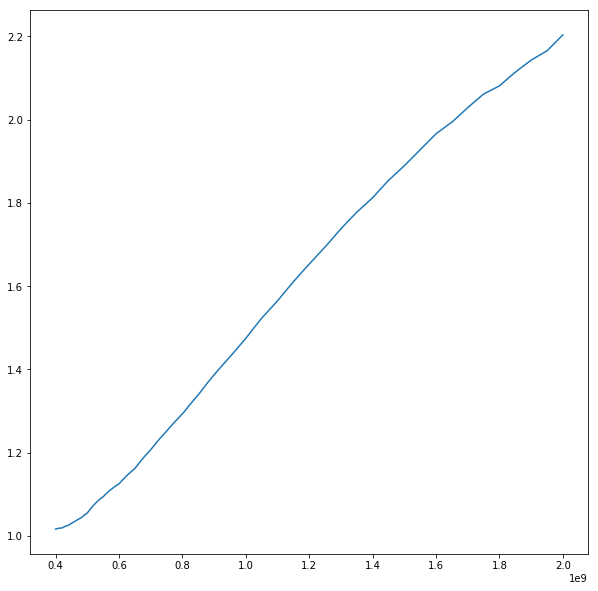

In [69]:
# let's calculate K again
delta2 = bjt_comp.s11.s*bjt_comp.s22.s - bjt_comp.s12.s*bjt_comp.s21.s
K2 = ((1 - sqabs(bjt_comp.s11.s) - sqabs(bjt_comp.s22.s) + sqabs(delta2))/(2*np.absolute(bjt_comp.s12.s*bjt_comp.s21.s)))[:,0,0]

plt.plot(bjt_comp.f, K2)

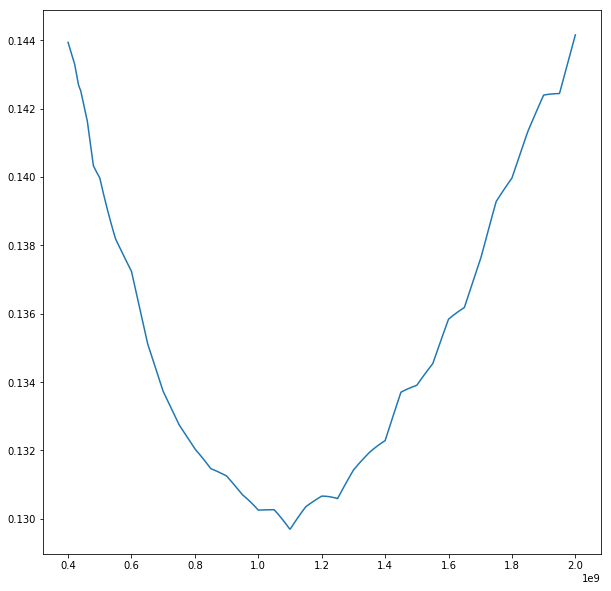

In [70]:
# that's a pretty nice improvement! let's check the delta to be sure, and
# find the new source stability circles to see if we need to add some series resistance there

# K > 1 and |delta| < 1 for stability
plt.plot(bjt_comp.f, np.absolute(delta2[:,0,0]))

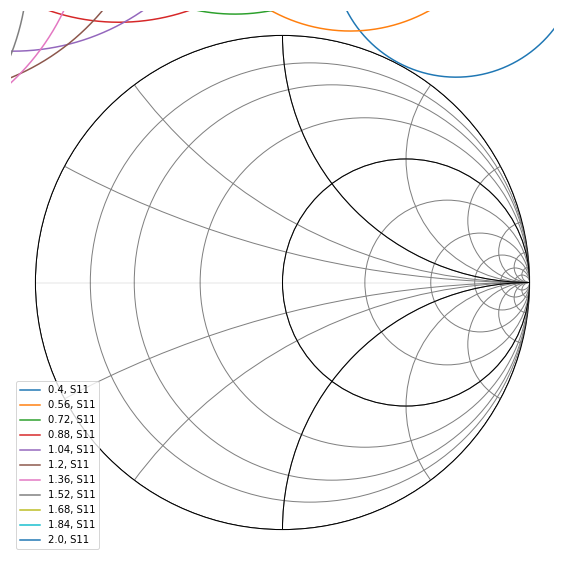

In [71]:
rs2 = np.absolute((bjt_comp.s12.s * bjt_comp.s21.s)/(sqabs(bjt_comp.s11.s) - sqabs(delta2)))
cs2 = np.conj(bjt_comp.s11.s - delta2*np.conj(bjt_comp.s22.s))/(sqabs(bjt_comp.s11.s) - sqabs(delta2))

# input stability
for i, f in enumerate(bjt_comp.f):
    if i % 100 != 0:
        continue
    n = net.Network(name=str(f/1.e+9), s=calc_circle(cs2[i][0, 0], rs2[i][0, 0]))
    n.plot_s_smith()

In [72]:
# that doesn't look too bad, so let's move forward and try to conjugate match
delta2 = bjt_comp.s11.s*bjt_comp.s22.s - bjt_comp.s12.s*bjt_comp.s21.s

B1 = 1 + sqabs(bjt_comp.s11.s) - sqabs(bjt_comp.s22.s) - sqabs(delta2)
B2 = 1 + sqabs(bjt_comp.s22.s) - sqabs(bjt_comp.s11.s) - sqabs(delta2)
C1 = bjt_comp.s11.s - delta2*np.conj(bjt_comp.s22.s)
C2 = bjt_comp.s22.s - delta2*np.conj(bjt_comp.s11.s)

gamma_s_all = (B1 - np.sqrt(np.square(B1) - 4*sqabs(C1) + 0j))/(2*C1)
gamma_l_all = (B2 - np.sqrt(np.square(B2) - 4*sqabs(C2) + 0j))/(2*C2)

gamma_s = gamma_s_all[idx_900mhz, 0, 0]
gamma_l = gamma_l_all[idx_900mhz, 0, 0]

z_s = net.s2z(np.array([[[gamma_s]]]))[0,0,0]
z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]

# this section broke when I switched to a lower bias current so just ignore this
z_s, z_l

((14.453769011425337+31.967494868137187j),
 (28.41148437701095+33.098424068469981j))

In [73]:
x_s_1, x_s_2 = calc_matching_network_vals(np.conj(z_s), 50)
x_l_1, x_l_2 = calc_matching_network_vals(np.conj(z_l), 50)

x_s_1, x_s_2, x_l_1, x_l_2

(54.634144641220715j,
 (1.0165472266293926e-07-31.88333775860665j),
 57.8645657612208j,
 (3.290115549532768e-07-57.35952884685131j))

In [75]:
c_s_shunt = np.real(1/(2j*np.pi*915e+6*x_s_1))
c_s_ser = np.real(1/(2j*np.pi*915e+6*x_s_2))
l_s_ser = np.real(x_s_2/(2j*np.pi*915e+6))
c_l_shunt = np.real(1/(2j*np.pi*915e+6*x_l_1))
l_l_ser = np.real(x_l_2/(2j*np.pi*915e+6))

c_s_shunt2 = np.real(1/(2j*np.pi*915e+6*x_s_2))
l_s_ser2 = np.real(x_s_1/(2j*np.pi*915e+6))

c_l_shunt2 = np.real(1/(2j*np.pi*915e+6*x_l_2))
l_l_ser2 = np.real(x_l_1/(2j*np.pi*915e+6))

#c_s_shunt, c_s_ser, c_l_shunt, l_l_ser
c_s_shunt2, l_s_ser2, c_l_shunt2, l_l_ser2

(5.4555087623716236e-12,
 9.503053749997663e-09,
 3.032448697062142e-12,
 1.0064952645644079e-08)

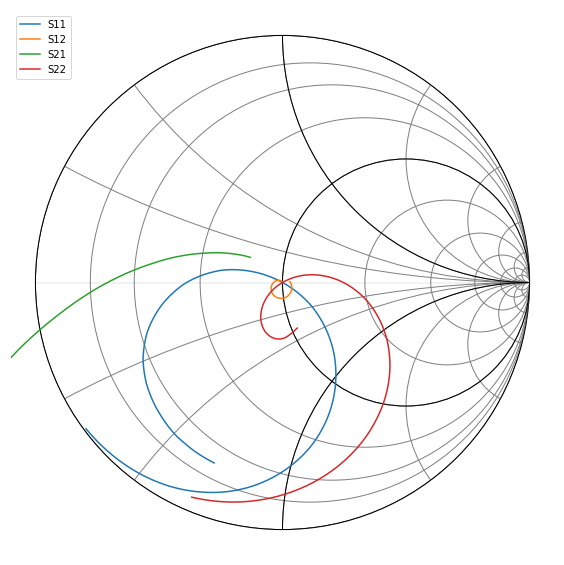

In [76]:
#input_network2 = tem.capacitor(c_s_ser) ** tem.shunt_capacitor(c_s_shunt)
#input_network2 = tem.inductor(l_s_ser) ** tem.shunt_capacitor(c_s_shunt)
input_network2 = tem.shunt_capacitor(c_s_shunt2) ** tem.inductor(l_s_ser2)

#output_network2 = tem.shunt_capacitor(c_l_shunt) ** tem.inductor(l_l_ser)
output_network2 = tem.inductor(l_l_ser2) ** tem.shunt_capacitor(c_l_shunt2)

amplifier2 = input_network2 ** bjt_comp ** output_network2
#amplifier2 = input_network2 ** bjt #** output_network2

amplifier2.plot_s_smith()

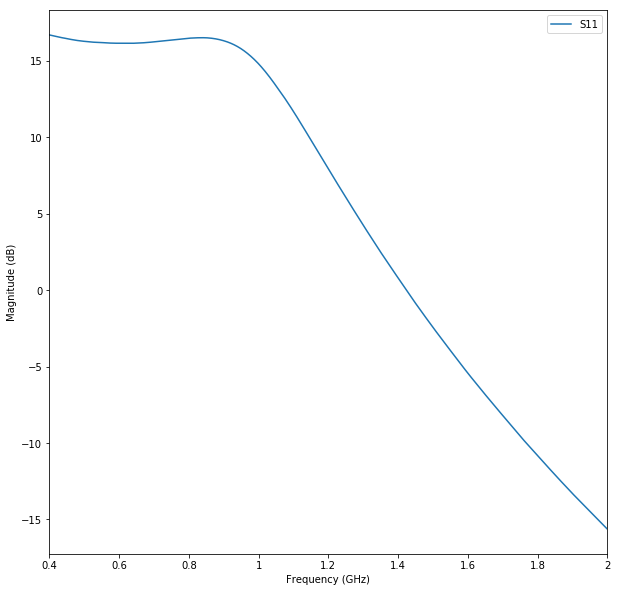

In [77]:
amplifier2.s21.plot_s_db()

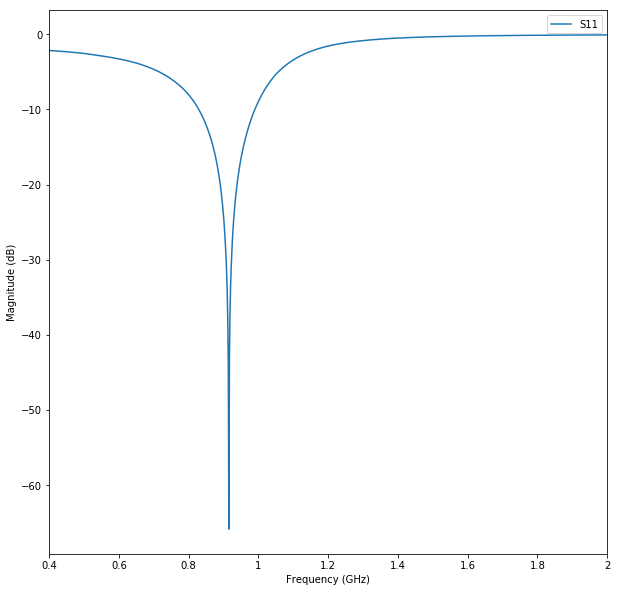

In [78]:
amplifier2.s11.plot_s_db()

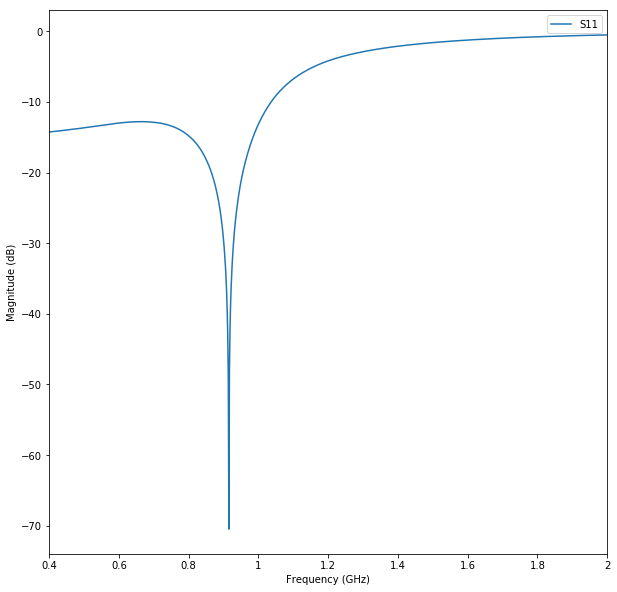

In [79]:
amplifier2.s22.plot_s_db()

In [80]:
10*np.log10(amplifier2.nf(50.)[idx_900mhz])

1.5225393220600005

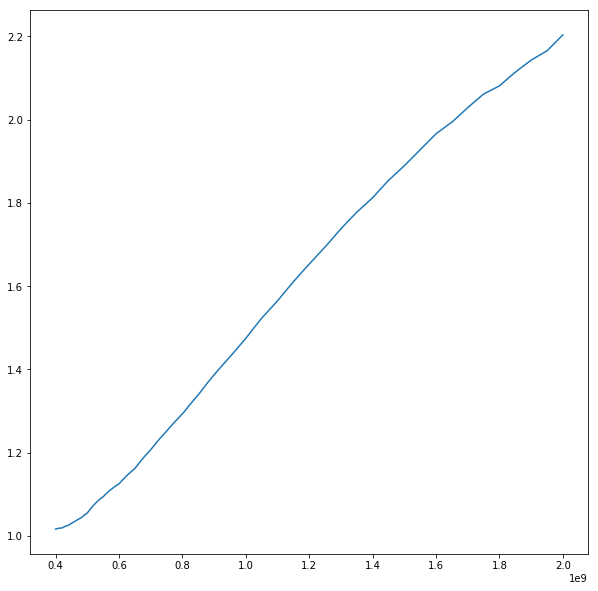

In [81]:
# check stability again
delta2 = amplifier2.s11.s*amplifier2.s22.s - amplifier2.s12.s*amplifier2.s21.s
K2 = ((1 - sqabs(amplifier2.s11.s) - sqabs(amplifier2.s22.s) + sqabs(delta2))/(2*np.absolute(amplifier2.s12.s*amplifier2.s21.s)))[:,0,0]

plt.plot(amplifier2.f, K2)

((16.211209907925852+25.548553377005881j),
 (31.935019262196562+53.460553910461819j))

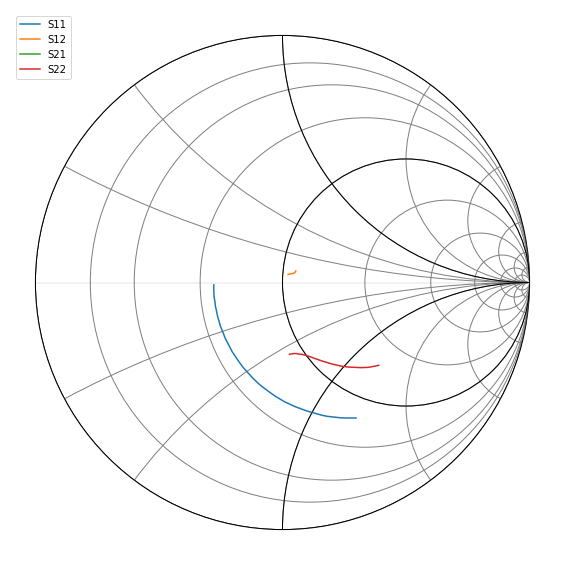

In [53]:
# of course, it matches the other one since all we did was transform the impedances at the input and output
# let's try again with 10 ohms of resistance in series with the base to stabilize that side

bjt_comp2 = tem.resistor(10) ** bjt_comp

delta3 = bjt_comp2.s11.s*bjt_comp2.s22.s - bjt_comp2.s12.s*bjt_comp2.s21.s

B1 = 1 + sqabs(bjt_comp2.s11.s) - sqabs(bjt_comp2.s22.s) - sqabs(delta3)
B2 = 1 + sqabs(bjt_comp2.s22.s) - sqabs(bjt_comp2.s11.s) - sqabs(delta3)
C1 = bjt_comp2.s11.s - delta3*np.conj(bjt_comp2.s22.s)
C2 = bjt_comp2.s22.s - delta3*np.conj(bjt_comp2.s11.s)

gamma_s_all = (B1 - np.sqrt(np.square(B1) - 4*sqabs(C1) + 0j))/(2*C1)
gamma_l_all = (B2 - np.sqrt(np.square(B2) - 4*sqabs(C2) + 0j))/(2*C2)

gamma_s = gamma_s_all[idx_900mhz, 0, 0]
gamma_l = gamma_l_all[idx_900mhz, 0, 0]

z_s = net.s2z(np.array([[[gamma_s]]]))[0,0,0]
z_l = net.s2z(np.array([[[gamma_l]]]))[0,0,0]

bjt_comp2.plot_s_smith()
z_s, z_l

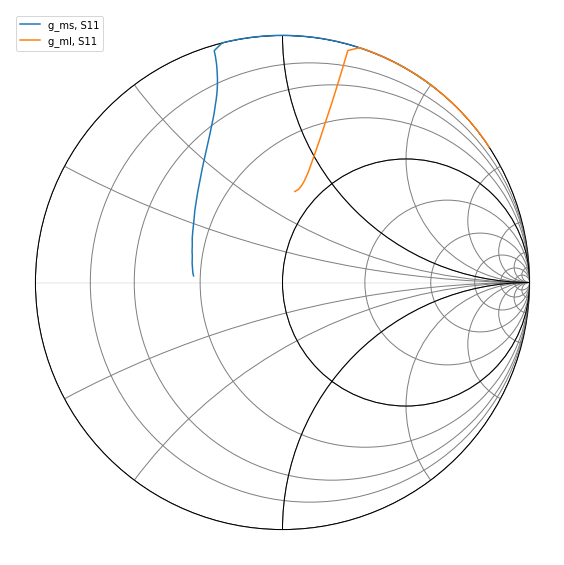

In [54]:
n = net.Network(name="g_ms", s=gamma_s_all)
n.plot_s_smith()
n = net.Network(name="g_ml", s=gamma_l_all)
n.plot_s_smith()

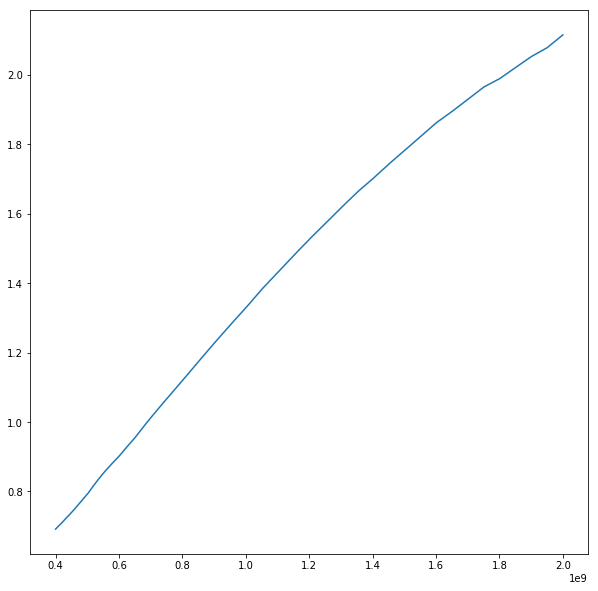

In [55]:
K3 = ((1 - sqabs(bjt_comp2.s11.s) - sqabs(bjt_comp2.s22.s) + sqabs(delta3))/(2*np.absolute(bjt_comp2.s12.s*bjt_comp2.s21.s)))[:,0,0]

plt.plot(bjt_comp2.f, K3)

In [56]:
x_s_1, x_s_2 = calc_matching_network_vals(np.conj(z_s), 50)
x_l_1, x_l_2 = calc_matching_network_vals(np.conj(z_l), 50)

x_s_1, x_s_2, x_l_1, x_l_2

(48.95276600459623j,
 (1.1994517903534313e-07-34.63310252278059j),
 77.47941124866512j,
 (4.419464892559804e-07-66.47905604444007j))

In [57]:
c_s_shunt = np.real(1/(2j*np.pi*915e+6*x_s_2))
l_s_ser = np.real(x_s_1/(2j*np.pi*915e+6))

l_l_ser = np.real(x_l_1/(2j*np.pi*915e+6))
c_l_shunt = np.real(1/(2j*np.pi*915e+6*x_l_2))

#c_s_shunt, c_s_ser, c_l_shunt, l_l_ser
c_s_shunt, l_s_ser, c_l_shunt, l_l_ser

(5.022357682258479e-12,
 8.514835724210252e-09,
 2.616460564654482e-12,
 1.3476755506092735e-08)

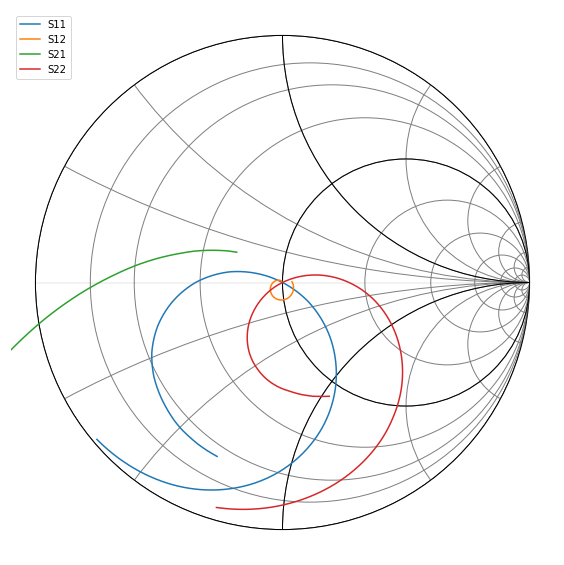

In [58]:
input_network3 = tem.shunt_capacitor(c_s_shunt) ** tem.inductor(l_s_ser)
output_network3 = tem.inductor(l_l_ser) ** tem.shunt_capacitor(c_l_shunt)

amplifier3 = input_network3 ** tem.resistor(10.) ** bjt_comp ** output_network3

amplifier3.plot_s_smith()

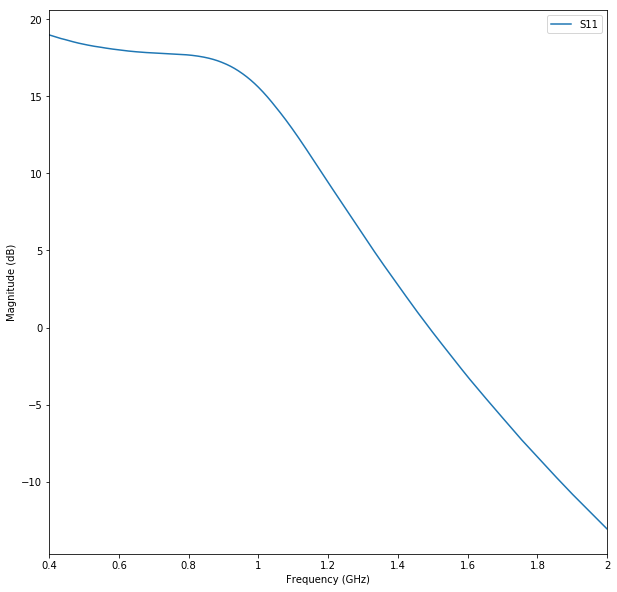

In [59]:
amplifier3.s21.plot_s_db()

In [60]:
10*np.log10(amplifier3.nf(50.)[idx_900mhz])

1.5079267817918054

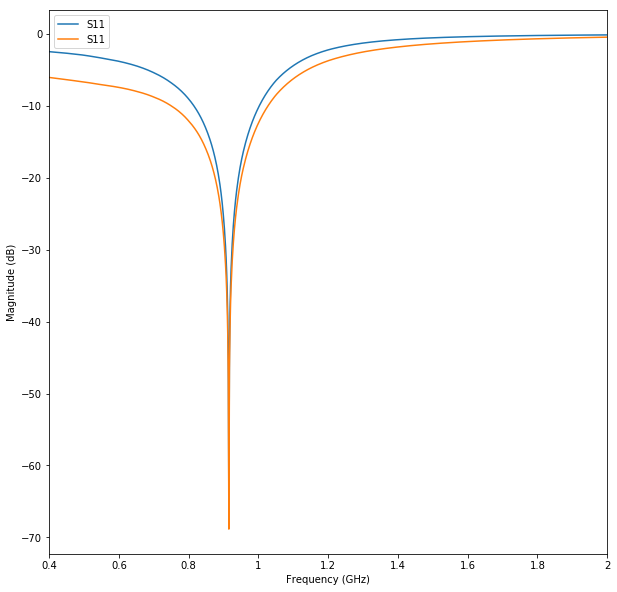

In [61]:
amplifier3.s11.plot_s_db()
amplifier3.s22.plot_s_db()

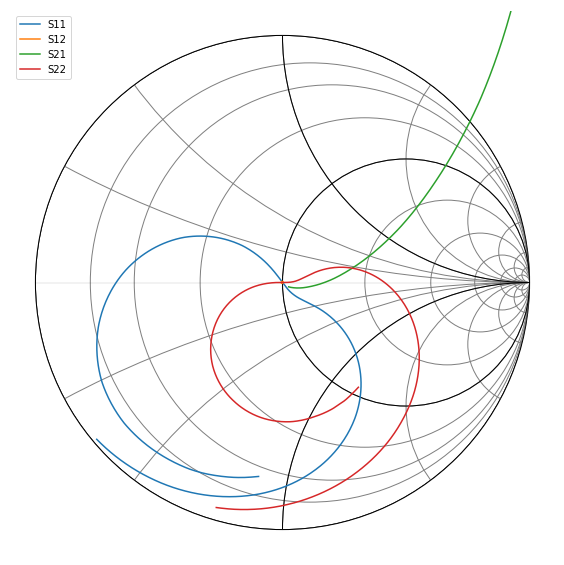

In [62]:
# let's see how it works cascaded

cascaded = amplifier3 ** amplifier3
cascaded.plot_s_smith()

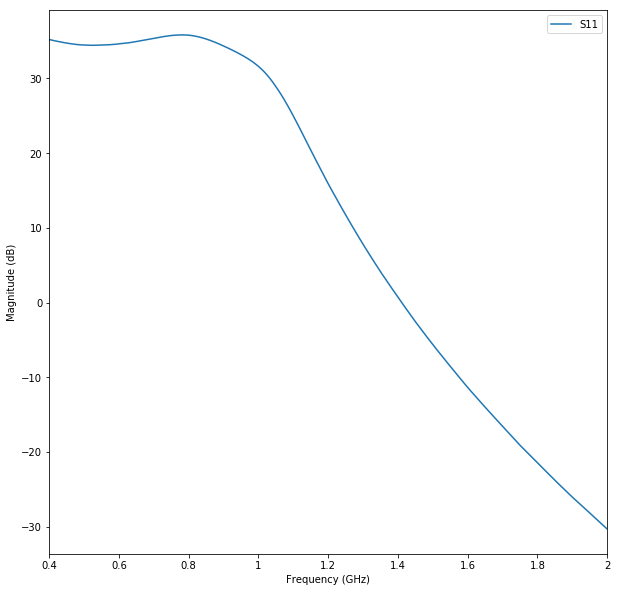

In [63]:
cascaded.s21.plot_s_db()

1.533262687029886

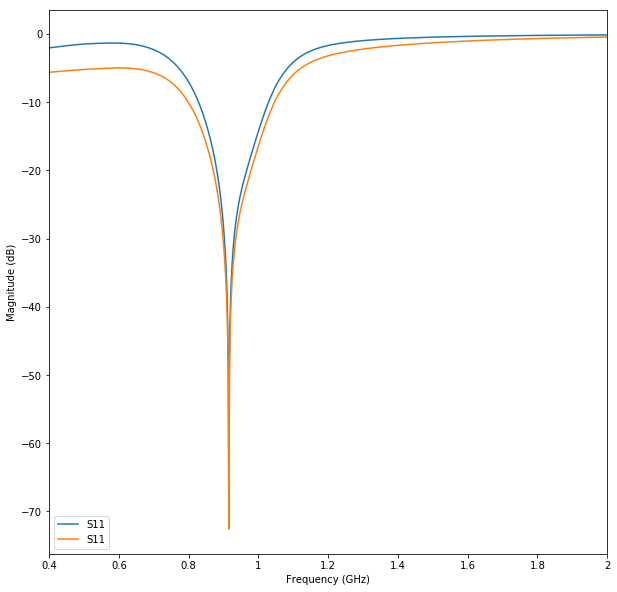

In [64]:
cascaded.s11.plot_s_db()
cascaded.s22.plot_s_db()
10*np.log10(cascaded.nf(50.)[idx_900mhz])